In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop = nn.Dropout2d(p=0.05)
        self.conv1 = nn.Conv2d(1, 32, 7, padding=3)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, 2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)        
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool2d(5)
        self.pool2 = nn.MaxPool2d(3)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 31)
    
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.drop(self.pool1(self.bn2(F.relu(self.conv2(x)))))
        x = self.bn2(F.relu(self.conv3(x)))
        x = self.pool2(self.bn3(F.relu(self.conv4(x))))
        x = self.bn3(F.relu(self.conv5(x)))
        x = self.pool3(self.bn4(F.relu(self.conv6(x))))
        x = x.view(-1, 256 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
class kaggle_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        dat = self.data[index]
        if self.transforms is not None:
            dat = self.transforms(dat)
        return (dat,self.labels[index])
   
    def __len__(self):
        return self.labels.shape[0]

In [4]:
def define_classes(labels):
    classes = {}
    label = []
    c = 0
    for i,j in labels:
        if j.decode('utf-8') not in classes:
            classes[j.decode('utf-8')] = c
            c += 1
        label.append(classes[j.decode('utf-8')])    
    return classes, torch.LongTensor(label)

In [5]:
def reshape_images(images):
    train_im = []
    #noise = torch.zeros(1,100,100)
    #c = 0
    #_,label = define_classes(train_labels)
    #for i in range(images.shape[0]):
    #    if label[i]==21:
    #        noise += torch.Tensor(images[i][1]).reshape((1,100,100)) / 255.
    #        c += 1.
    #noise /= c   
    for i in range(images.shape[0]):
        train_im.append(torch.Tensor(images[i][1].reshape((1,100,100))) / 255.)
    return train_im

In [6]:
def train(images, labels, nepochs):
    
    transform = transforms.Compose(
        [transforms.ToPILImage(), transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
#     transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = kaggle_dataset(
        reshape_images(images)[:9500],define_classes(labels)[1][:9500],
        transforms=transform)
    
    testset = kaggle_dataset(
        reshape_images(images)[9500:],define_classes(labels)[1][9500:],
        transforms=transform)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=250,
                                          shuffle=True, num_workers=0)

    testloader = torch.utils.data.DataLoader(testset, batch_size=250,
                                         shuffle=False, num_workers=0)

    classes = [str(i) for i in range(31)]
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=0.025, weight_decay=0.01,
        momentum=0.9)
    
    loss_train = []
    loss_test = []
    err_train = []
    err_test = []
    for epoch in range(nepochs):  # loop over the dataset multiple times
        if epoch>20:
            optimizer = optim.SGD(net.parameters(), lr=0.01,
                weight_decay=0.01, momentum=0.9)
        if epoch>30: #was30
            optimizer = optim.SGD(net.parameters(), lr=0.005,
                weight_decay=0.01, momentum=0.9)
#         if epoch>30: #was40
#             optimizer = optim.SGD(net.parameters(), lr=0.0005,
#                 weight_decay=0.0001, momentum=0.9)
        correct = 0.
        total = 0.
        running_loss_train = 0.0
        running_loss_test = 0.0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() / 9500
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
        err_train.append(1 - correct / total)

        correct = 0.
        total = 0.
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = net(images.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.to(device)).sum().item()
                loss = criterion(outputs, labels.to(device))
                running_loss_test += loss.item() / 500
        err_test.append(1 - correct / total)
        
        loss_train.append(running_loss_train)
        loss_test.append(running_loss_test)
        print('Epoch: {}'.format(epoch))
        print('Train loss: {0:.4f} Train error: {1:.2f}'.format(
            loss_train[epoch], err_train[epoch]))
        print('Test loss: {0:.4f} Test error: {1:.2f}'.format(
            loss_test[epoch], err_test[epoch]))       
    print('Finished Training')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print('Accuracy of the network on the 500 test images: %d %%' % (
        100 * correct / total))

    class_correct = list(0. for i in range(31))
    class_total = list(0. for i in range(31))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.to(device)).squeeze()
            for i in range(c.shape[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(31):
        if class_total[i]!=0:
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i]/class_total[i]))
        else:
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i]))
    return net, loss_train, loss_test, err_train, err_test

In [7]:
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    for i in range(images.shape[0]):
        augmented_images.append(4*i)
        augmented_images.append(images[i][1].reshape(100,100))
        augmented_images.append(4*i+1)
        augmented_images.append(np.flip(images[i][1].reshape(100,100), axis = 0))
        augmented_images.append(4*i+2)
        augmented_images.append(np.flip(images[i][1].reshape(100,100), axis = 1))
        augmented_images.append(4*i+3)
        augmented_images.append(np.transpose(images[i][1].reshape(100,100)))
        augmented_labels.append((4*i, labels[i][1]))
        augmented_labels.append((4*i+1, labels[i][1]))
        augmented_labels.append((4*i+2, labels[i][1]))
        augmented_labels.append((4*i+3, labels[i][1]))
    return np.array(augmented_images, dtype = object).reshape(-1, 2), np.array(augmented_labels, dtype=[('Id', 'i8'), ('Category', 'S5')])

In [9]:
train_labels = np.genfromtxt('train_labels.csv',names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])
images_train = np.load('train_images.npy',encoding='latin1')
#images_train, train_labels = augment_data(images_train, train_labels)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
torch.cuda.get_device_name(0)

'GeForce GTX 1070 Ti'

Epoch: 0
Train loss: 0.0134 Train error: 0.94
Test loss: 0.0129 Test error: 0.91
Epoch: 1
Train loss: 0.0124 Train error: 0.90
Test loss: 0.0118 Test error: 0.87
Epoch: 2
Train loss: 0.0111 Train error: 0.83
Test loss: 0.0105 Test error: 0.80
Epoch: 3
Train loss: 0.0104 Train error: 0.79
Test loss: 0.0099 Test error: 0.75
Epoch: 4
Train loss: 0.0096 Train error: 0.75
Test loss: 0.0090 Test error: 0.69
Epoch: 5
Train loss: 0.0089 Train error: 0.70
Test loss: 0.0087 Test error: 0.69
Epoch: 6
Train loss: 0.0084 Train error: 0.66
Test loss: 0.0083 Test error: 0.62
Epoch: 7
Train loss: 0.0080 Train error: 0.62
Test loss: 0.0078 Test error: 0.58
Epoch: 8
Train loss: 0.0077 Train error: 0.59
Test loss: 0.0078 Test error: 0.57
Epoch: 9
Train loss: 0.0074 Train error: 0.57
Test loss: 0.0071 Test error: 0.54
Epoch: 10
Train loss: 0.0071 Train error: 0.54
Test loss: 0.0069 Test error: 0.49
Epoch: 11
Train loss: 0.0068 Train error: 0.52
Test loss: 0.0067 Test error: 0.49
Epoch: 12
Train loss: 0.00

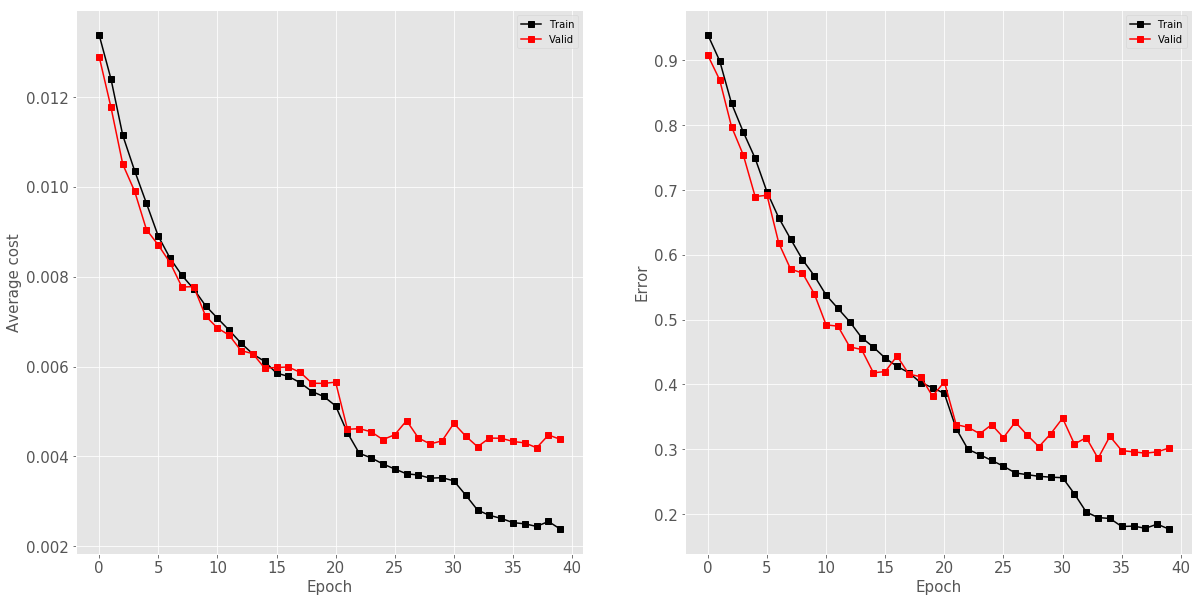

In [12]:
torch.cuda.manual_seed(10)
plt.style.use('ggplot')     
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

nepochs = 40
t1 = time.time()    
net, loss_train, loss_test, e_train, e_test = train(images_train, train_labels, nepochs = nepochs)    
print(time.time()-t1)
torch.cuda.empty_cache()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
ax1, ax2 = ax.flatten()

ax1.plot(range(nepochs),loss_train, 'sk-', label='Train')
ax1.plot(range(nepochs),loss_test, 'sr-', label='Valid')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average cost')
ax1.legend()

ax2.plot(range(nepochs),e_train, 'sk-', label='Train')
ax2.plot(range(nepochs),e_test, 'sr-', label='Valid')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Error')
ax2.legend()
plt.show()

In [35]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [47]:
torch.cuda.empty_cache()

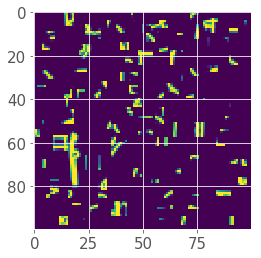

In [27]:
plt.imshow((images_train[1][1].reshape((100, 100))/255.).T)